In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from tqdm.auto import tqdm
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from utils import *
from flow import *
import os
import torch.multiprocessing
from pathlib import Path
import sys
from matplotlib import offsetbox
import torch.optim as optim
from MNIST.classifier_test import * 
from MNIST.digits_model import *
from torch.utils.data.dataloader import default_collate
import pandas as pd
import seaborn as sns
import copy
import cv2 as cv
import math

In [2]:
def show_tensor_images(image_tensor, num_images=200, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
#     image_tensor = image_tensor*0.2712+0.1266
#     image_tensor[torch.where(image_tensor<0)] =0
#     image_tensor[torch.where(image_tensor>1)] =1
#     image_tensor = 1.0-image_tensor
    image_unflat = image_tensor.detach().cpu()
    plt.figure(figsize=(20,10))
    image_grid = make_grid(image_unflat[:num_images], nrow=10,normalize=True,scale_each=True)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

device = "cuda:0"
classifier = LeNet5()


old_model = torch.load("./models/FMNIST_lenet_19.tar")['best_model']
classifier.load_state_dict(old_model) 

classifier = classifier.to(device)
for name, param in classifier.named_parameters():
    print(name, param.data[:3])
    break

for name, param in classifier.named_parameters():
    print(name, param.data[:3])
    break
# for param in new_model.feature.parameters():
#     param.requires_grad = False


conv1.weight tensor([[[[-0.1608,  0.2279,  0.1493,  0.3793,  0.4299],
          [ 0.0450,  0.2478, -0.0270,  0.0675,  0.0685],
          [ 0.2514,  0.0706,  0.0388,  0.0932, -0.0048],
          [ 0.2141, -0.0335, -0.1613, -0.0875, -0.1290],
          [ 0.1258,  0.1522, -0.2629, -0.2177, -0.2272]]],


        [[[ 0.2084,  0.1169,  0.3634,  0.2222,  0.1343],
          [-0.0785, -0.0144,  0.1543,  0.0575,  0.0603],
          [ 0.0497,  0.2535,  0.1518, -0.3097, -0.0648],
          [ 0.1599,  0.0761,  0.0150, -0.3063, -0.2504],
          [-0.2820, -0.1579, -0.2264, -0.6285,  0.0608]]],


        [[[-0.5485, -0.4309,  0.3768,  0.3301,  0.1920],
          [-0.3412, -0.2932,  0.3542,  0.1255,  0.1073],
          [-0.3347, -0.3329,  0.1813,  0.0980,  0.2137],
          [-0.1934, -0.1913,  0.1629,  0.2154,  0.1506],
          [-0.3341, -0.1434,  0.2240,  0.0811, -0.0766]]]], device='cuda:0')
conv1.weight tensor([[[[-0.1608,  0.2279,  0.1493,  0.3793,  0.4299],
          [ 0.0450,  0.2478, -0.02

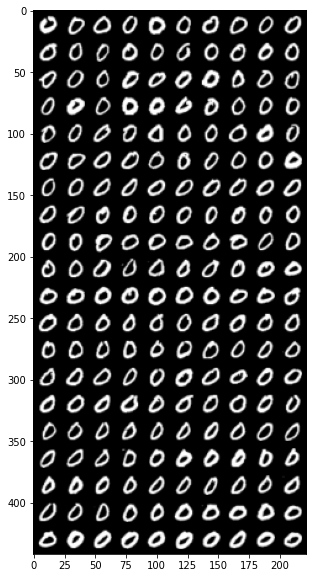

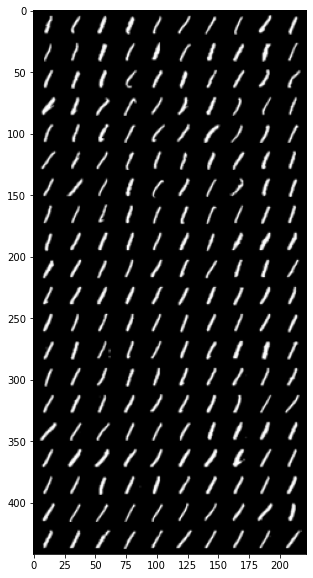

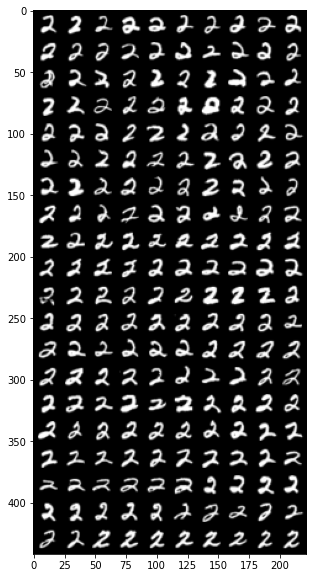

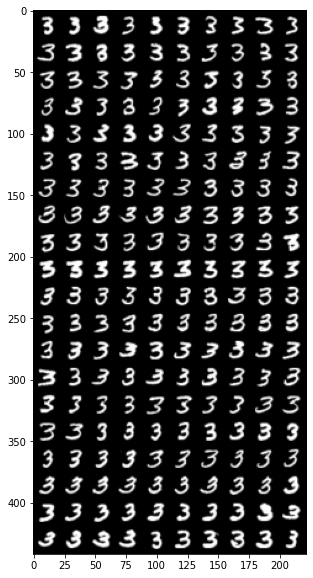

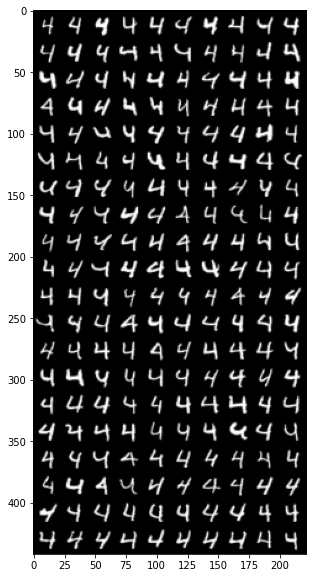

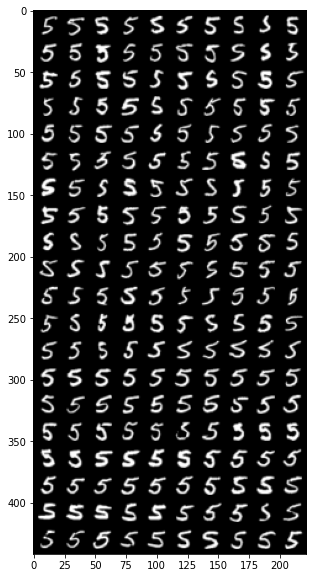

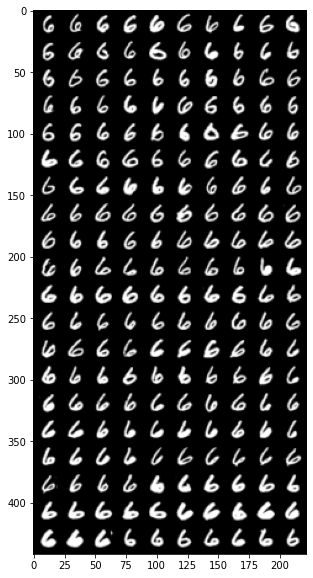

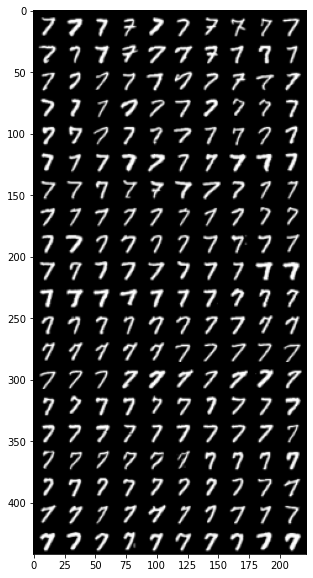

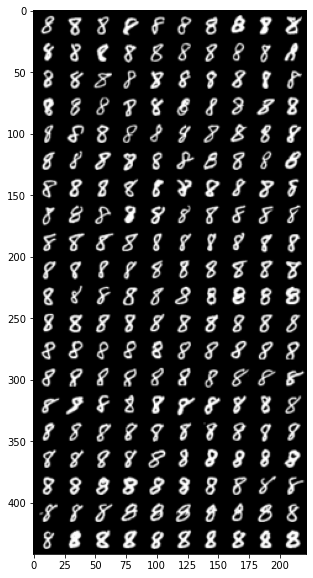

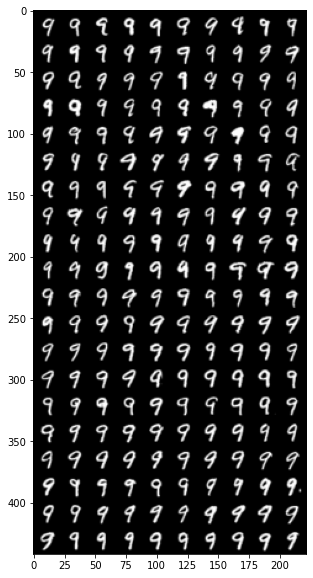

torch.Size([2948, 1, 20, 20]) torch.Size([2948])


In [3]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

def Union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

def my_collate(batch):
    modified_batch = []
    for item in batch:
        image, label = item
        if label <5:
            modified_batch.append(item)
    return default_collate(modified_batch)

transform = transforms.Compose([
    torchvision.transforms.Resize((20,20)),
    transforms.ToTensor()
])

test_set = datasets.MNIST(root='/home/ubuntu/datasets/', train=False, download = True, transform=transform)
# MNIST_test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8,collate_fn = my_collate)
MNIST_test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

device = 'cuda:0'
data_path = "./data/FMNIST_MNIST.tar"
data = torch.load(data_path,map_location=torch.device(device))
source_data = data["source_data"].to(device).float()
source_mean = data["source_mean"].to(device).float()
source_cov = data["source_cov"].to(device).float()
target_data = data["target_data"].to(device).float()
target_data_cpu = data["target_data"].float().cpu().numpy()
target_mean = data["target_mean"].to(device).float()
target_cov = data["target_cov"].to(device).float()
clustered_labels = data["labels"]

cleaned_test = []
cleaned_labels = []
one_class = 300
for c in range(10):
    idx = 0
    images = torch.zeros((1000,20,20))
    for _, (inputs, label) in enumerate(MNIST_test_loader, 0):      
        size = len(np.where(label==c)[0])
        if idx+size>1000:
            break
        images[idx:idx+size]=inputs[label==c].squeeze()
        idx +=size
            
            
    kmeans_images = torch.cat((target_data[one_class*c:one_class*c+5].cpu(),images.reshape(-1,400).cpu()))   
    neighs = 300
    nbrs = NearestNeighbors(n_neighbors=neighs, algorithm='ball_tree').fit(kmeans_images)
    distances, indices = nbrs.kneighbors(kmeans_images)
    kept_indices = []
    for i in range(1):
        kept_indices = Union(kept_indices,indices[i])   
    final_indices = list(filter(lambda x: x >5, kept_indices))
    cleaned_test.append(kmeans_images[final_indices])
    show_tensor_images(kmeans_images[final_indices].reshape(-1,1,20,20))
    labels = torch.zeros(len(final_indices))+c
    labels = labels.type(torch.LongTensor)
    cleaned_labels.append(labels)
    
cleaned_test = torch.cat(cleaned_test).reshape(-1,1,20,20)
cleaned_labels = torch.cat(cleaned_labels)
print(cleaned_test.shape, cleaned_labels.shape)

test = torch.utils.data.TensorDataset(cleaned_test,cleaned_labels)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)

In [4]:
def train_few_shots(classifier, images, labels): 
    images=images.to("cpu")
    train = torch.utils.data.TensorDataset(images,labels)
    loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4)
    
    optimizer = optim.Adam(classifier.parameters(), lr = 2e-3, weight_decay=1e-6)
    best_classifier = None
    best_accuracy = 0
    for _ in range(10):
        for _, (image,label) in enumerate(loader,0):
            data = image.to(device).reshape(-1,1,20,20)
            label = label.to(device)
            data.requires_grad=True
#             show_tensor_images(data.reshape(-1,1,20,20),1)
#             print(label)
            optimizer.zero_grad()
            outputs = classifier(data)

            loss = celoss(outputs, label)               
            loss.backward()
            optimizer.step()
        ac = test_model(classifier, test_loader)
        if ac>best_accuracy:
            best_classifier = classifier
            best_accuracy = ac
    return best_classifier

def test_model(classifier, test_loader):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            #inputs = torch.cat((inputs, inputs, inputs), 1)    
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = classifier(inputs)
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels.data).sum()

        correct = 1. * correct / total
#         print('accuracy: %.3f%%' % (100 * correct))
    return correct           

['09_08_03_52', '09_08_03_33', '09_08_01_11', '09_08_01_51', '09_08_01_32', '09_08_02_11', '09_08_02_51', '09_08_02_31', '09_08_04_11', '09_08_03_12']
09_08_03_52


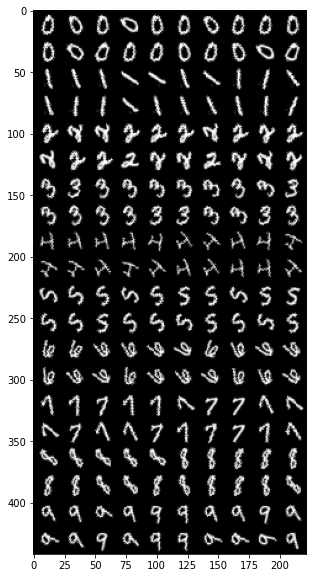

few shot D_beta tensor(0.5750, device='cuda:0')


KeyboardInterrupt: 

In [7]:
path = "../UAI_supp_data_code_edited/Gaussian/1_shot/"
directories = os.listdir(path)
print(directories)
indices = np.arange(len(directories))
method_list = []
accuracy_list = []

celoss = nn.CrossEntropyLoss()

# two simple data augmentation methods
random_rotate = torchvision.transforms.RandomRotation(degrees=(0, 90))
blurrer = torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

d_beta_zt = 0
d_beta_zt_z0 = 0

for ii in indices:
    d = directories[ii]
    if d[0]=='.':
        continue
    flow_path=path+d+'/'
    print(d)
    img = cv.imread(flow_path+"init_target.png",0)/255.0

    img = 1.0-img
    padding = 0
    horizontal = 10
    num_class = 10
    num_target = 10
    one_class = num_target/num_class

    #one_shot
#     denom =5
    #five shot
    denom =1
    
    target_labels = np.zeros(int(num_target/denom))
    target_images = torch.zeros(int(num_target/denom),20,20)
        
        
    for i in range(0,num_target):
        y=int(i/horizontal)
        x = i-horizontal*y
        start_pixel_x = padding+y*(20+padding)
        start_pixel_y = padding+x*(20+padding)
        image=torch.from_numpy(img[start_pixel_x:start_pixel_x+20, start_pixel_y:start_pixel_y+20]).float().unsqueeze(0).unsqueeze(0)
        target_images[int(i)] = image
        target_labels[int(i)]=math.floor(i/one_class)
        
#     show_tensor_images(target_images.reshape(-1,1,20,20))
    target_labels = torch.from_numpy(target_labels).type(torch.LongTensor)
    
    img = cv.imread(flow_path+"init_source.png",0)/255.0
    img = 1.0-img
    num_images = 200
    source_labels = np.zeros(num_images)
    source_images = torch.zeros(num_images,20,20)
    
    one_class_source = 20
    for i in range(num_images):
        source_labels[i]=int(i/one_class_source)
    for i in range(num_images):
        y=int(i/horizontal)
        x = i-horizontal*y
        start_pixel_x = padding+y*(20+padding)
        start_pixel_y = padding+x*(20+padding)
        image=torch.from_numpy(img[start_pixel_x:start_pixel_x+20, start_pixel_y:start_pixel_y+20]).float().unsqueeze(0).unsqueeze(0)
        source_images[i] = image

    source_images = source_images.reshape(-1,1,20,20)
    source_labels = torch.from_numpy(source_labels).type(torch.LongTensor)
#     print(source_images.shape, source_labels.shape)
    
    data = torch.load(flow_path+"140.tar",map_location=torch.device(device))
    x_tau = data["source_data"].to(device).float()
    x_tau = images.reshape(-1,400).to(device).float()
    mean_tau = data["source_mean"].to(device).float()
    cov_tau = data["source_cov"].to(device).float()
    labels = data["labels"]

#     1_shot
    final_images = torch.zeros(source_images.shape)
    image_index = 0
    labels = torch.ones(200)
    for iteration in range(10):
        for _ in range(20):
            # use data augmentation methods
            rotate_image = random_rotate(target_images[iteration].unsqueeze(0))
            final_images[image_index,0,:,:] = rotate_image
            labels[image_index] = iteration
            image_index += 1
    x_tau = final_images.reshape(-1,400).to(device).float()
    labels = labels.type(torch.LongTensor)    
    show_tensor_images(final_images.reshape(-1,1,20,20))
#     # 5_shot
#     print(target_images.shape)
#     final_images = torch.zeros(source_images.shape)
#     image_index = 0
#     labels = torch.ones(200)
#     for iteration in range(target_images.shape[0]):
#         for _ in range(4):
#             rotate_image = blurrer(target_images[iteration].unsqueeze(0))
#             final_images[image_index,0,:,:] = rotate_image
#             labels[image_index] = int(iteration/5)
#             image_index += 1
#     x_tau = final_images.reshape(-1,400).to(device).float()
#     labels = labels.type(torch.LongTensor)    
 
    #only using the few shots
#     print(target_labels)
    classifier_plain = LeNet5().to(device)
    
    classifier_plain = train_few_shots(classifier_plain, target_images, target_labels)
    accuracy = test_model(classifier_plain, test_loader)
    print("few shot D_beta",accuracy)  
    method_list.append("D_beta")
    accuracy_list.append(accuracy.item())
     
        
#     classifier1 = copy.deepcopy(classifier_plain)
#     classifier2 = copy.deepcopy(classifier_plain)
#     classifier3 = copy.deepcopy(classifier_plain)
    classifier_plain2 = LeNet5().to(device)
    classifier_plain2 = train_few_shots(classifier_plain2, final_images, labels)
    accuracy = test_model(classifier_plain2, test_loader)
    print("few shot zT, D_beta: ",accuracy) 
    d_beta_zt +=accuracy
    method_list.append("D_beta, zT")
    accuracy_list.append(accuracy.item())
    
    accuracy = test_model(classifier, test_loader)
    print("few shot z0: ",accuracy)
    method_list.append("z0")
    accuracy_list.append(accuracy.item()) 
    
    classifier1 = copy.deepcopy(classifier)
    classifier2 = copy.deepcopy(classifier)
    
    # #only train with the few shots target
#     classifier_few = train_few_shots(classifier1, target_images, target_labels)
    classifier_few = train_few_shots(classifier1, target_images, target_labels)
    
    accuracy = test_model(classifier_few, test_loader)
    print("few shot z0, D_beta: ",accuracy) 
    method_list.append("D_beta, z0")
    accuracy_list.append(accuracy.item())

    #train our Z_T images
    final_images = final_images.reshape(-1,20,20)
    all_data = torch.cat((target_images,final_images.cpu()))
    all_labels= torch.cat((target_labels,labels))
    
#     classifier2 = train_few_shots(classifier2, source_images, source_labels)
    classifier2 = train_few_shots(classifier2, all_data, all_labels)
#     classifier2 = train_few_shots(classifier2, target_images, target_labels)
    accuracy = test_model(classifier2, test_loader)
    print("few shot z0, D_beta, zT: ",accuracy)
    d_beta_zt_z0 +=accuracy
    method_list.append("D_beta, zT, z0")
    accuracy_list.append(accuracy.item())
    
print(accuracy_list)
accuracy_list = np.array(accuracy_list)
print(method_list)
raw_data={
    'x':method_list,
#     'y':[accuracy_z0,accuracy_few,accuracy_zt]
    'y':accuracy_list
}
ax = sns.barplot(x="x", y="y", data=raw_data, capsize=.2)
# ax.set_xlabel("methods")
ax.set_ylabel("accuracy")

In [6]:
D_beta = accuracy_list[np.where(np.array(method_list)=='D_beta')]
print(np.average(D_beta))
D_beta_zT = accuracy_list[np.where(np.array(method_list)=='D_beta, zT')]
print(np.average(D_beta_zT))
z0 = accuracy_list[np.where(np.array(method_list)=='z0')]
print(np.average(z0))
D_beta_z0 = accuracy_list[np.where(np.array(method_list)=='D_beta, z0')]
print(np.average(D_beta_z0))
D_beta_zT_z0 = accuracy_list[np.where(np.array(method_list)=='D_beta, zT, z0')]
print(np.average(D_beta_zT_z0))

0.5296133100986481
0.4993894249200821
0.09701492637395859
0.5023744940757752
0.5639416605234147
